In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- SPC parameters (Eq. 11)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997

# --- IRF parameters (Jeltsch-Thömmes & Joos, 2019)
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521.0, 5312.0, 362.0, 47.0, 6.0], dtype=float)


In [7]:
#functions
def f_SPC(t):
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)

def IRF(t):
    t = np.asarray(t, dtype=float)
    if t.ndim == 0:
        return a0 + np.sum(a*np.exp(-t/tau))
    return a0 + np.sum(a*np.exp(-t[:, None]/tau), axis=1)

def y(t):
    return f_SPC(t) * IRF(t)

def trapz(yvals, xvals):
    yvals = np.asarray(yvals, dtype=float)
    xvals = np.asarray(xvals, dtype=float)
    return np.sum((yvals[1:] + yvals[:-1]) * 0.5 * (xvals[1:] - xvals[:-1]))

def integral_numeric(H, n=20_000):
    t = np.linspace(0.0, float(H), n+1)
    return trapz(y(t), t)

def integral_analytic(H):
    H = float(H)

    const_part = a0 * (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )

    exp_part = 0.0
    for ai, taui in zip(a, tau):
        lam = 1.0/taui
        exp_part += ai * (
            a1_spc*(1.0 - np.exp(-(k1 + lam)*H))/(k1 + lam) +
            a2_spc*(1.0 - np.exp(-(k2 + lam)*H))/(k2 + lam)
        )

    return const_part + exp_part


Integral_analytic(H=20) = 11.151239311334 yr  this is the value to use for TCE calculation
Integral_numeric (H=20) = 11.151239323956 yr  this is a sanity check using 20000 trapezoids.
abs diff = 1.262e-08 yr


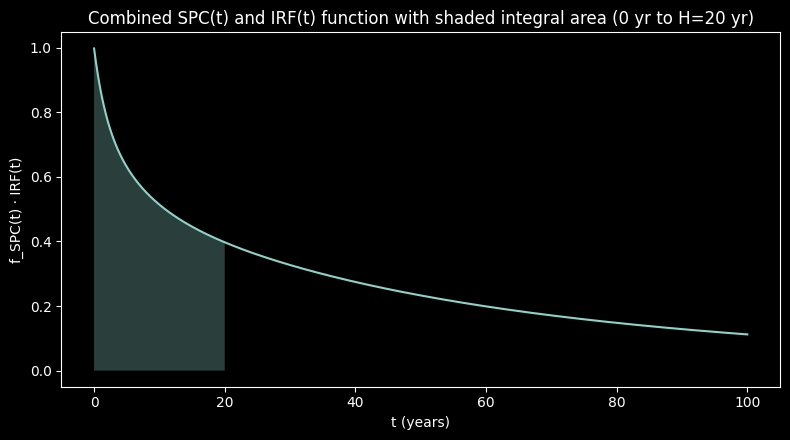

In [8]:
# --- User choices (edit here)
H = 20
n = 20_000

val_a = integral_analytic(H)
val_n = integral_numeric(H, n=n)

print(f"Integral_analytic(H={H}) = {val_a:.12f} yr  this is the value to use for TCE calculation")
print(f"Integral_numeric (H={H}) = {val_n:.12f} yr  this is a sanity check using {n} trapezoids.")
print(f"abs diff = {abs(val_n - val_a):.3e} yr")


# --- Plot choices
tmax = 100
dt = 0.1

t = np.arange(0.0, tmax + dt, dt)
yvals = y(t)

mask = (t <= H)

plt.figure(figsize=(8, 4.5))
plt.plot(t, yvals)
plt.fill_between(t[mask], 0, yvals[mask], alpha=0.3)
plt.xlabel("t (years)")
plt.ylabel("f_SPC(t) · IRF(t)")
plt.title(f"Combined SPC(t) and IRF(t) function with shaded integral area (0 yr to H={H} yr)")
plt.tight_layout()
plt.show()
